# Human Emotion Detection - Farid's Notebook

In [1]:
import os
import pathlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import seaborn as sns

# import numpy as np
import tensorflow as tf

random_state = 42

%matplotlib inline

In [2]:
# For Google Colab Only
# Mount GDrive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# For Google Colab Only
# Put Colab in the context of this challenge

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir("/content/drive/MyDrive/Colab Notebooks/EmoSense/notebooks")

## Exploratory Data Analysis (EDA)

### Loading and Cleaning the Data

In [4]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "raw_data")
cache_path = pathlib.Path(cwd, "..", "cache")

df = pd.DataFrame(columns=["filename", "label"])
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            filelist = [f.name for f in os.scandir(entry_path)]
            df = pd.concat(
                [df, pd.DataFrame({"filename": filelist, "label": entry.name})]
            )

df.reset_index(inplace=True, drop=True)
df.describe()

,filename,label
count,5558,5558
unique,5233,8
top,2Q__ (2)_face.png,happiness
freq,6,1406


It looks like some files appear in multiple folders. We need to make sure these are not actual duplicate images. Because if that is the case, it makes the problem one of "multilabel" image classification. First, let's find out how many file _names_ are duplicated...

In [5]:
dups = df[df["filename"].duplicated(keep=False)]
dups["filename"].nunique()

125

Let's take a look at some of these...

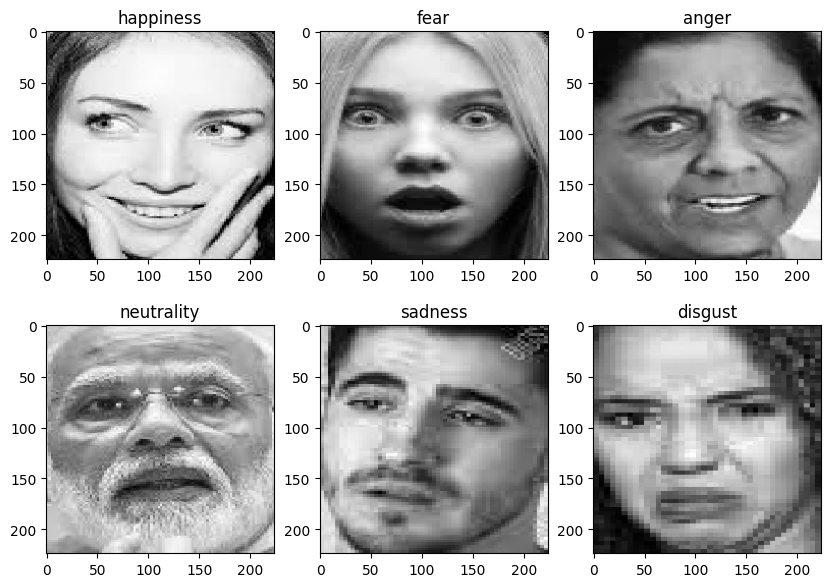

In [6]:
fig = plt.figure(figsize=(10, 7))
i = 0
for row in df.query("filename == 'images (55)_face.png'").iterrows():
    filename = row[1][0]
    label = row[1][1]
    path = os.path.join(data_path, label, filename)
    ax = fig.add_subplot(2, 3, i + 1)
    img = mpimg.imread(path)
    ax.imshow(img, cmap="gray")
    ax.title.set_text(label)
    i = i + 1

Looks like they're actually different images. We've only looked at one duplicated file name but hopefully it's safe to assume this applies to all the other ones as well 🤞 and we can continue with multiclass classification.  
For future reference and in case we do need to drop duplicates in the future:
```python
df = df.drop_duplicates(subset=["filename"], keep=False)
df.describe()
```

### Data Imbalance

Now let's take a look at the distribution of labels...

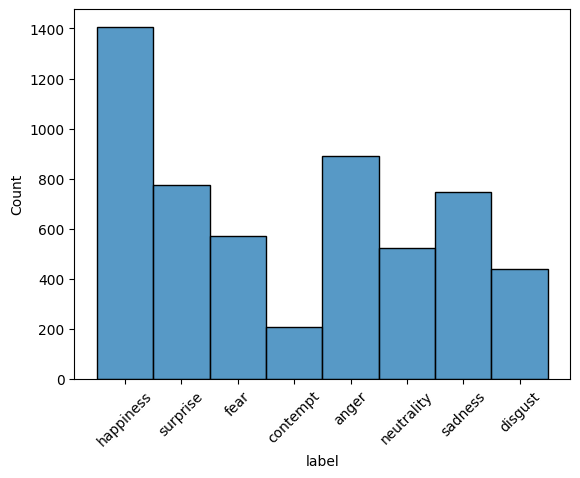

In [7]:
ax = sns.histplot(df.label)
ax.tick_params(axis="x", rotation=45);

The data looks quite unbalanced...  
**<u>TO DO</u>:** Use stratified sampling or try balancing the dataset using over/under-sampling methods (SMOTE, etc.), data augmentation, etc. 

## Preparing the Data

Let's encode the labels first. We could use `sklearn.preprocessing.OneHotEncoder`, but I'd like to use `tf.keras.utils.to_categorical` this time...

In [8]:
i = 0
label_dict = {}
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            label_dict[entry.name] = i
        i = i + 1
label_dict

{'happiness': 0,
 'surprise': 1,
 'fear': 2,
 'contempt': 3,
 'anger': 4,
 'neutrality': 5,
 'sadness': 6,
 'disgust': 7}

In [9]:
df["label_int"] = df.label.apply(lambda x: label_dict[x])

df.sample(n=5)

,filename,label,label_int
3689,images - 2020-11-06T004504.353_face.png,anger,4
5142,images (54)_face.png,disgust,7
224,images - 2020-11-06T193227.458_face.png,happiness,0
3638,images - 2020-11-06T004636.442_face.png,anger,4
5542,images - 2020-11-05T231242.774_face.png,disgust,7


In [10]:
from tensorflow.keras.utils import to_categorical

n_classes = len(label_dict)
y = to_categorical(df.label_int, n_classes)
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's also replace the `filename` column with the full path to each file to make things easier...

In [11]:
df["filepath"] = df.apply(
    lambda x: os.path.join(data_path, x["label"], x["filename"]), axis=1
)
df.drop(columns="filename", inplace=True)

In [12]:
df.sample(n=5)

,label,label_int,filepath
5499,disgust,7,/content/drive/MyDrive/Colab Notebooks/EmoSens...
4508,sadness,6,/content/drive/MyDrive/Colab Notebooks/EmoSens...
3935,neutrality,5,/content/drive/MyDrive/Colab Notebooks/EmoSens...
3590,anger,4,/content/drive/MyDrive/Colab Notebooks/EmoSens...
4639,sadness,6,/content/drive/MyDrive/Colab Notebooks/EmoSens...


In [13]:
X = df.filepath
X

0       /content/drive/MyDrive/Colab Notebooks/EmoSens...
1       /content/drive/MyDrive/Colab Notebooks/EmoSens...
2       /content/drive/MyDrive/Colab Notebooks/EmoSens...
3       /content/drive/MyDrive/Colab Notebooks/EmoSens...
4       /content/drive/MyDrive/Colab Notebooks/EmoSens...
                              ...                        
5553    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5554    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5555    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5556    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5557    /content/drive/MyDrive/Colab Notebooks/EmoSens...
Name: filepath, Length: 5558, dtype: object

Now we have everything we need in order to create the training, validation and test data sets.

In [14]:
# Next, some common CONSTants...

BATCH_SIZE = 32
IMG_DIM = 224  # height = width
N_CHANNELS = 3  # The input images are greyscale but we need RGB in order to use pre-trained models

# Note: In Python 3.7+ dictionaries are ordered.
class_names = list(label_dict.keys())

We will explore two ways of creating the `Dataset` objects. Use the flag below to toggle between them.

In [15]:
# This flag controls whether to go down the "manual" route (False) or use the TensorFlow.Keras utility function (True)
USE_TF_KERAS_UTIL = True

### Route 1: Manually Creating `tf.data.Dataset` Objects

Now some preprocessing and helper functions...

In [16]:
# In order to do 'transfer learning' using VGG16, ResNet, etc. our image needs to have three channels.
# Some images already have 3 channels even if they're grayscale PNGs. For all others, we will simply duplicate the one channel 2 more times.
def expand_greyscale_image_channels(image):
    if image.shape[-1] == 1:
        grey_image_3_channel = tf.tile(image, tf.constant([1, 1, 3], tf.int32))
    else:
        grey_image_3_channel = image

    return grey_image_3_channel

In [17]:
# A function to parse image files and generate a tensor representing the features and a tensor representing the labels.
def parse_function(filepath, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filepath)

    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=N_CHANNELS)

    # Resize it to fixed shape
    image_resized = (
        tf.image.resize(image_decoded, [IMG_DIM, IMG_DIM])
    )

    # Convert it to a 3-channel image if necessary
    image_rgb = expand_greyscale_image_channels(image_resized)

    # Normalize it from [0, 255] to the appropriate range expected by the
    # pretrained model
    image_normalized = tf.keras.applications.vgg16.preprocess_input(image_rgb)

    # Prepare the labels
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)

    return image_normalized, label_tensor

In [18]:
BATCH_SIZE = BATCH_SIZE  # If using Soft Macro F1 as the loss function, use a big enough number to measure a meaningful F1-score (256+)

AUTOTUNE = (
    tf.data.experimental.AUTOTUNE
)  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

SHUFFLE_BUFFER_SIZE = (
    512  # Shuffle the training data by chuncks of this number of observations (e.g. 1024)
)

In [19]:
def create_dataset(filepaths, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache(str(cache_path)) # Once again: if training locally, reduce batch size or else you'll run out of RAM
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [20]:
if not USE_TF_KERAS_UTIL:
    filepaths = df.filepath.to_list()
    labels = df.label

    from sklearn.model_selection import train_test_split

    X_train, X_val_test, y_train, y_val_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=random_state
    )

    ds_train = create_dataset(X_train, y_train)
    ds_val = create_dataset(X_val, y_val)
    ds_test = create_dataset(X_test, y_test)

### Route 2: Automatically (Using TensorFlow Keras Utility `image_dataset_from_directory`)

Turns out we didn't need to do any of that, because `tf.keras.utils.image_dataset_from_directory` will take care of everything for us.

In [21]:
def preprocess(images, labels):
  return tf.keras.applications.vgg16.preprocess_input(images), labels

if USE_TF_KERAS_UTIL:
    ds_train, ds_val_test = tf.keras.utils.image_dataset_from_directory(
        directory=data_path,
        labels="inferred",
        label_mode="categorical",
        class_names=class_names,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMG_DIM, IMG_DIM),
        shuffle=True,
        seed=random_state,
        validation_split=0.2,
        subset="both",
    )
    ds_train = ds_train.map(preprocess)
    ds_val_test = ds_val_test.map(preprocess)

Found 5558 files belonging to 8 classes.
Using 4447 files for training.
Using 1111 files for validation.


In [22]:
if USE_TF_KERAS_UTIL:
    val_test_batches = tf.data.experimental.cardinality(ds_val_test)
    ds_val = ds_val_test.take(val_test_batches // 2)
    ds_test = ds_val_test.skip(val_test_batches // 2)

## Modeling

### Basline Model

What would be a good baseline model and score to use as a reference point?

In [23]:
# TO DO

### Transfer Learning

Let's get a pre-trained model and fine-tune it to our task.

In [24]:
# Some more CONSTants...

LR = 1e-5
N_EPOCHS = 200

DO_1 = 0.4
DO_2 = 0.2
L2_REG_1 = 0.01
L2_REG_2 = 0.003

In [25]:
def get_pretrained_model():
    model_pretrained = tf.keras.applications.vgg16.VGG16(
        include_top=False, input_shape=(IMG_DIM, IMG_DIM, N_CHANNELS)
    )
    model_pretrained.trainable = True
    return model_pretrained

In [26]:
pretrained = get_pretrained_model()
pretrained.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [27]:
def get_compiled_custom_model(num_classes):
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(
        100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_1)
    )
    dropout_layer_1 = tf.keras.layers.Dropout(DO_1)
    dense_layer_2 = tf.keras.layers.Dense(
        50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_2)
    )
    dropout_layer_2 = tf.keras.layers.Dropout(DO_2)
    # dense_layer_3 = tf.keras.layers.Dense(
    #     25, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    # )
    # dropout_layer_3 = tf.keras.layers.Dropout(DO3)
    prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dropout_layer_1,
            dense_layer_2,
            dropout_layer_2,
            # dense_layer_3,
            # dropout_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [28]:
model = get_compiled_custom_model(num_classes=n_classes)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4

In [30]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = model.fit(
    ds_train, epochs=N_EPOCHS, validation_data=ds_val, verbose=1, callbacks=[es]
)

Epoch 1/200
139/139 [==============================] - 1200s 8s/step - loss: 4.8698 - accuracy: 0.1673 - val_loss: 4.0731 - val_accuracy: 0.2169
Epoch 2/200
139/139 [==============================] - 25s 177ms/step - loss: 4.0807 - accuracy: 0.1961 - val_loss: 3.9662 - val_accuracy: 0.2390
Epoch 3/200
139/139 [==============================] - 24s 168ms/step - loss: 3.9607 - accuracy: 0.2278 - val_loss: 3.8643 - val_accuracy: 0.2849
Epoch 4/200
139/139 [==============================] - 26s 178ms/step - loss: 3.8561 - accuracy: 0.2478 - val_loss: 3.7751 - val_accuracy: 0.2463
Epoch 5/200
139/139 [==============================] - 25s 176ms/step - loss: 3.7394 - accuracy: 0.2710 - val_loss: 3.6675 - val_accuracy: 0.2941
Epoch 6/200
139/139 [==============================] - 26s 185ms/step - loss: 3.6233 - accuracy: 0.3029 - val_loss: 3.5315 - val_accuracy: 0.3456
Epoch 7/200
139/139 [==============================] - 26s 184ms/step - loss: 3.4827 - accuracy: 0.3411 - val_loss: 3.3601 - 

In [31]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Categorical Cross-Entropy ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Categorical Cross-Entropy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Accuracy ---

    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

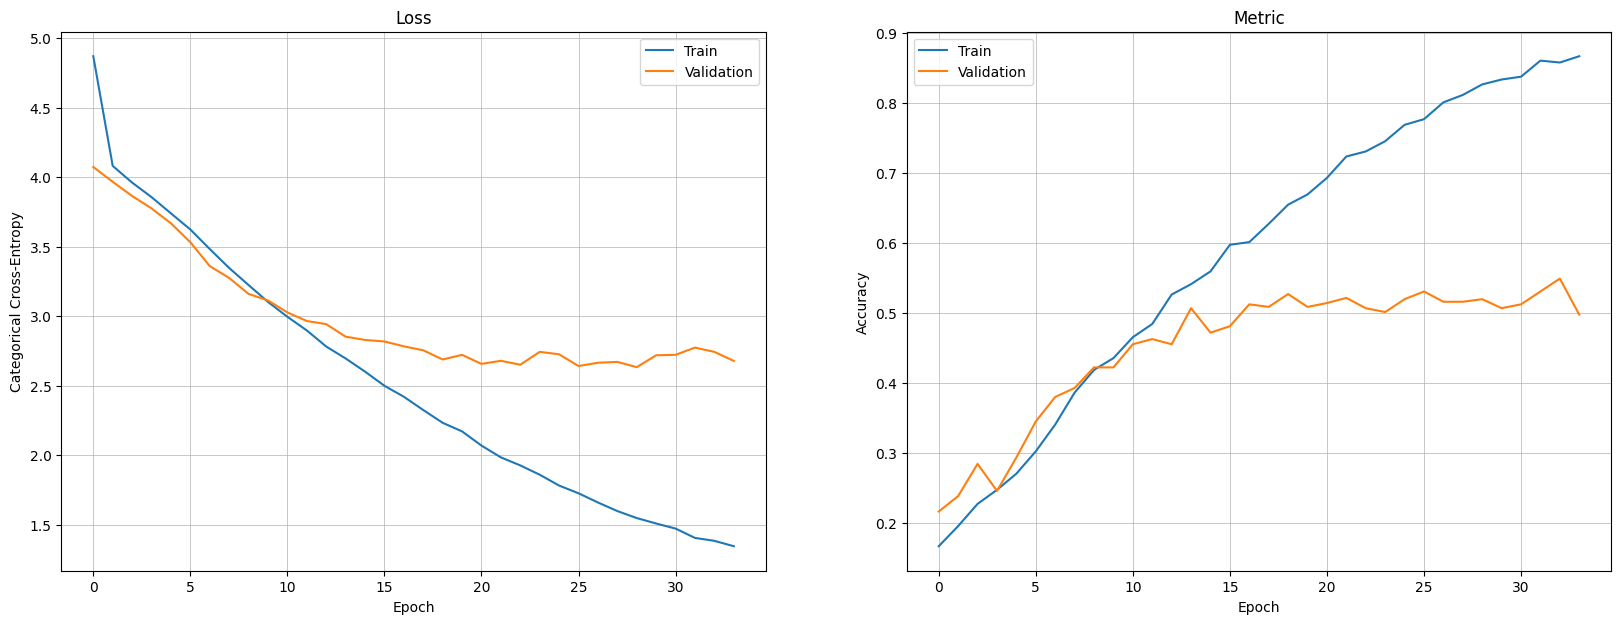

In [32]:
plot_history(history);

In [33]:
model.save("model.h5")

In [34]:
import pickle
pickle.dump(history, open("model_history.pkl", "wb"))

In [35]:
# import tensorflow as tf
# loaded_model = tf.keras.models.load_model(
#     "model.h5",
#     compile=True,
# )

In [36]:
res = model.evaluate(ds_test, return_dict=True)
res

18/18 [==============================] - 130s 8s/step - loss: 2.6028 - accuracy: 0.5291


{'loss': 2.6027891635894775, 'accuracy': 0.5291005373001099}

In [37]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_test:  # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    #    y_pred.append(preds)
    #    y_pred.append((preds > 0.5))
    y_pred.append((preds > 0.5) * 1)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

1/1 [==============================] - 0s 155ms/step


In [38]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score
print(classification_report(correct_labels, predicted_labels, target_names=label_dict.keys()))

              precision    recall  f1-score   support

   happiness       0.81      0.66      0.73       160
    surprise       0.70      0.58      0.63        83
        fear       0.56      0.30      0.39        60
    contempt       0.00      0.00      0.00        24
       anger       0.46      0.40      0.43        84
  neutrality       0.43      0.19      0.26        47
     sadness       0.31      0.15      0.21        71
     disgust       0.44      0.21      0.29        38

   micro avg       0.61      0.41      0.49       567
   macro avg       0.46      0.31      0.37       567
weighted avg       0.56      0.41      0.47       567
 samples avg       0.41      0.41      0.41       567



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
